## Import Libraries and Data

In [3]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_20-26-03-23.csv', firstRow=198, lastRow=204)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_210323_S199-204.csv',t_baseline=30,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [4]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=62s and ended at t=472s; mass=44.917449999999995g
This equals a volume of 45.007m; expected was 45.051mL; error is 0.097%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0015 g/s and for 2nd derivative = 0.00043750000000000006 g/s^2


<IPython.core.display.Javascript object>


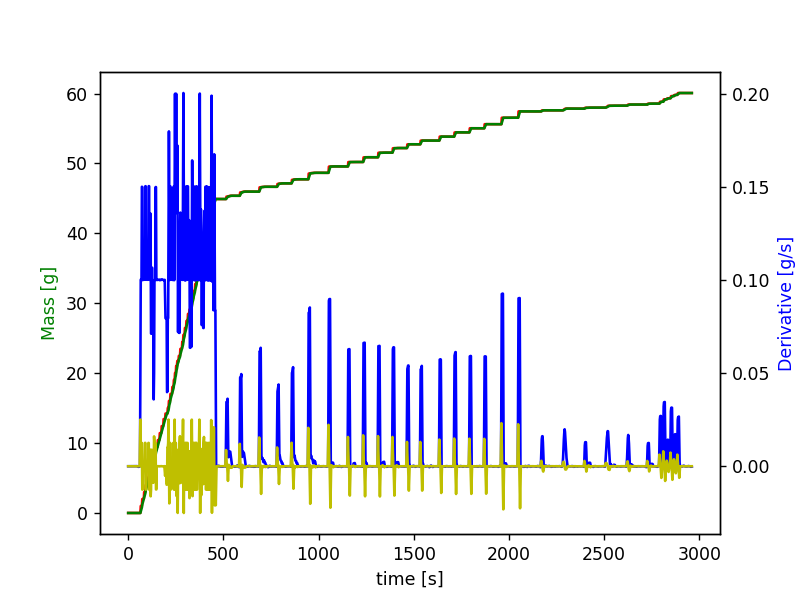

Addition of 0.471g Plantapon LC 7 detected from 510s to 548s - expected volume = 0.518mL and actual volume = 0.44mL (resulting error is 14.959%)
Addition of 0.595g Plantapon LC 7 detected from 582s to 620s - expected volume = 0.518mL and actual volume = 0.557mL (resulting error is 7.516%)
Addition of 0.699g Plantacare 818 detected from 684s to 726s - expected volume = 0.794mL and actual volume = 0.645mL (resulting error is 18.779%)
Addition of 0.488g Plantacare 2000 detected from 778s to 814s - expected volume = 0.526mL and actual volume = 0.451mL (resulting error is 14.253%)
Addition of 0.59g Plantacare 2000 detected from 854s to 892s - expected volume = 0.526mL and actual volume = 0.545mL (resulting error is 3.603%)
Addition of 0.932g Plantacare 2000 detected from 942s to 988s - expected volume = 0.868mL and actual volume = 0.848mL (resulting error is 2.235%)
Addition of 0.915g Dehyton MC detected from 1048s to 1082s - expected volume = 0.905mL and actual volume = 0.847mL (resulting 

In [5]:
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0021875 g/s and for 2nd derivative = 0.0007812499999999998 g/s^2


<IPython.core.display.Javascript object>


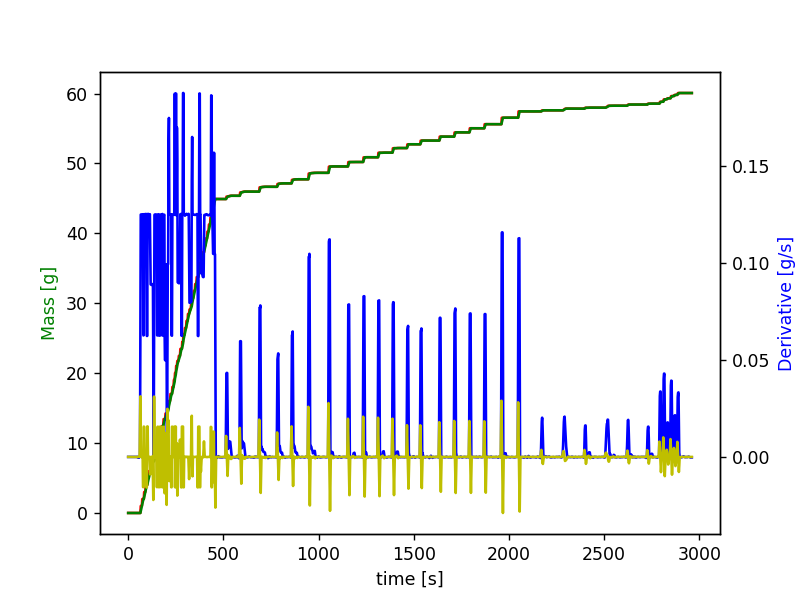

Addition of 0.157g Luviquat Excellence detected from 2164s to 2184s - expected volume = 0.162mL and actual volume = 0.142mL (resulting error is 12.079%)
Addition of 0.256g Luviquat Excellence detected from 2280s to 2308s - expected volume = 0.232mL and actual volume = 0.233mL (resulting error is 0.245%)
Addition of 0.126g Luviquat Excellence detected from 2392s to 2410s - expected volume = 0.116mL and actual volume = 0.113mL (resulting error is 2.035%)
Addition of 0.292g Luviquat Excellence detected from 2418s to 2532s - expected volume = 0.26mL and actual volume = 0.262mL (resulting error is 0.995%)
Addition of 0.166g Luviquat Excellence detected from 2616s to 2636s - expected volume = 0.15mL and actual volume = 0.149mL (resulting error is 0.749%)
Addition of 0.121g Luviquat Excellence detected from 2722s to 2740s - expected volume = 0.114mL and actual volume = 0.108mL (resulting error is 4.921%)


In [6]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.0015625 g/s^2


<IPython.core.display.Javascript object>


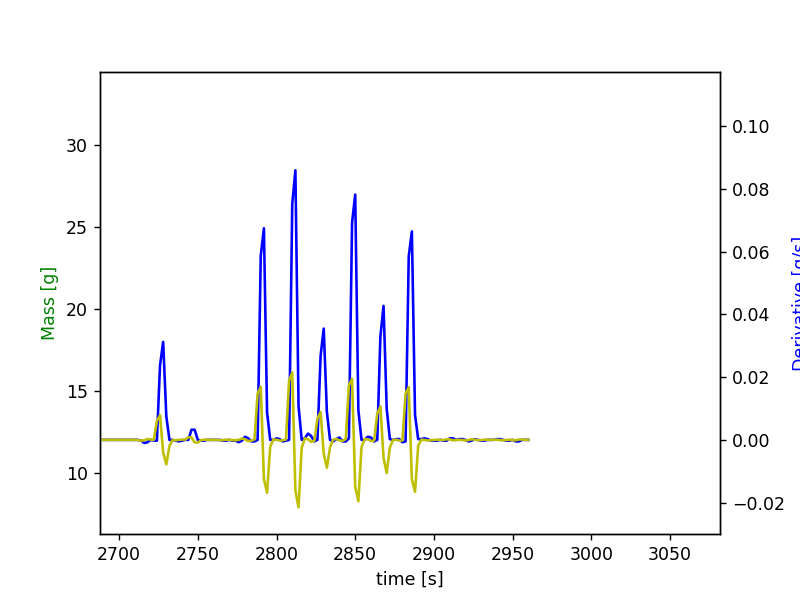

Addition of 0.269g Arlypon TT detected from 2786s to 2800s - expected volume = 0.303mL and actual volume = 0.282mL (resulting error is 6.92%)
Addition of 0.347g Arlypon TT detected from 2806s to 2820s - expected volume = 0.335mL and actual volume = 0.365mL (resulting error is 8.934%)
Addition of 0.144g Arlypon TT detected from 2824s to 2838s - expected volume = 0.105mL and actual volume = 0.148mL (resulting error is 40.686%)
Addition of 0.315g Arlypon TT detected from 2844s to 2858s - expected volume = 0.304mL and actual volume = 0.326mL (resulting error is 7.143%)
Addition of 0.173g Arlypon TT detected from 2862s to 2876s - expected volume = 0.132mL and actual volume = 0.179mL (resulting error is 35.156%)
Addition of 0.266g Arlypon TT detected from 2880s to 2894s - expected volume = 0.256mL and actual volume = 0.275mL (resulting error is 7.258%)


In [7]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=5, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [8]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_210323_S199-S204.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_22936\352983146.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
198,199.0,0.0,0.0,0.000000,0.00000,0.000000,9.091038,13.115267,0.0,0.0,0.0,0.0,0.000000,1.555425,0.0,0.0,0.0,0.0,2.673543
199,200.0,0.0,0.0,0.000000,6.99841,10.794684,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,2.561157,0.0,0.0,0.0,0.0,3.481671
200,201.0,0.0,0.0,10.635847,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,11.801419,1.261123,0.0,0.0,0.0,0.0,1.432017
201,202.0,0.0,0.0,0.000000,0.00000,9.243692,0.000000,0.000000,0.0,0.0,0.0,0.0,11.689297,2.895785,0.0,0.0,0.0,0.0,3.125215
202,203.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,13.035248,0.0,0.0,0.0,0.0,9.253138,1.630390,0.0,0.0,0.0,0.0,1.701704
203,204.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,10.667170,0.0,0.0,0.0,0.0,8.954983,1.198530,0.0,0.0,0.0,0.0,2.640241
